## Evrişimli Sinir Ağları (CNN) ile Katı Atık Tespiti
* 1) İş Problemi (Business Problem)
* 2) Veriyi Anlamak (Data Understanding)
* 3) Veriyi Hazırlamak (Data Preparation) 
* 4) Modelleme (Modeling)
* 5) Değerlendirme (Evaluation)

### 1) İŞ PROBLEMİ
Katı atık sınıflandırma problemini çözmek için izlenecek adımlar. Plastik, kağıt, cam, metal vs gibi bu katı atıkları sınıflandırma problemimiz var. Peki neden böyle bir problemle ilgileniyoruz? Hızlı kentleşme, artan insan nüfusu ve toplumun tüketim odaklı bir yaşayış biçimine sahip olması segibi sebepler tüm dünyada çevre kirliliğine sebep olmaktadır. Atıkların geri dönüşümü dünya ekonomisi ve iklim dengesi açısından da oldukça önemli bir hale gelmiştir. Bundan dolayı geri dönüştürülebilir çöplerin sınıflandırılması ve geri dönüştürülerek tekrar kullanılması çevre kirliliğini azaltmak için önemli bir imkan sağlar.

Bizim amacımızda katı atık sınıflandırma işlemini otomatize ederek insan gücü ihtiyacını makinelere devretmektir. Yani bir atık geldiğinde bunu bir insanın ayırması yerine bunu bir görüntü işleme problemi olarak ele alıp makinelerin bu atıkları ayırt etmesini sağlayacak altyapıyı hazırlamış olacağız.

### 2) Veriyi Anlamak (Data Understanding)
**Veri Seti Hikayesi**

Bu proje kapsamında kullanacağımız veri seti TrashNet isimli veri setidir. Stanford Üniversitesi 
öğrencileri tarafından hazırlanılmıştır.

Veri seti altı farklı sınıftan oluşmaktadır. Veri setinde Cam, Kağıt, Karton, Plastik, Metal ve Çöp olmak üzere toplamda 2527 adet görüntü bulunmaktadır.

Görüntülerin dağılımı:
*  501 cam
*  594 kağıt
*  403 karton
*  482 plastik 
*  410 metal
*  137 çöp
Görüntüler, beyaz bir panoya yerleştirilerek ve güneş ışığı veya oda aydınlatması kullanılarak çekilmiştir. Görüntüler, 512 x 384 piksel boyutlarında ve 3 (RGB) kanallıdır.

garbage-classification	rakam-projesi-2-foto


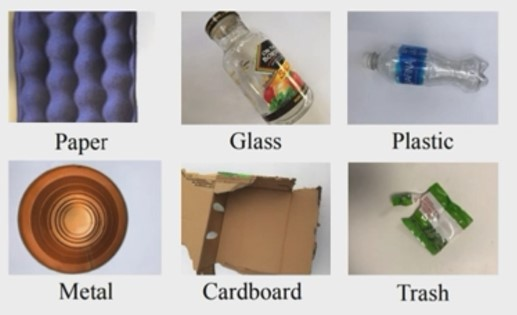

In [1]:
from IPython.display import Image
import os
!ls ../input/
Image("/kaggle/input/rakam-projesi-2-foto/1.jpg")

Ancak resimler bu şekilde tekli oalrak karşımıza çıkmayacak, gürültülü halde yani farklı ortamlarda karşımıza çıkacak.

#### 2.1) Gerekli Kütüphanelerin Import İşlemleri

The imutils library is a set of convenience functions for OpenCV (Open Source Computer Vision Library) in Python. It provides various utility functions for resizing, displaying, and working with images in OpenCV. It's often used to simplify common image processing tasks when working with OpenCV.

In [2]:
pip install imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25838 sha256=ff17b9ded7d4ec5fe299d72cfa6cc35a051c024432d1d3b107cdce80127cee1a
  Stored in directory: /root/.cache/pip/wheels/85/cf/3a/e265e975a1e7c7e54eb3692d6aa4e2e7d6a3945d29da46f2d7
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Veriyi okuma ve işleme adımında kullanılacak olan kütüphaneler
import cv2
import urllib
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import random, os, glob
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from urllib.request import urlopen

# Warningleri kapatmak için kullanılmaktadır.
import warnings
warnings.filterwarnings("ignore")

# Model değerlendirme için kullanılacak olan kütüphaneler
from sklearn.metrics import confusion_matrix, classification_report

# Model için kullanılacak olan kütüphaneler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 2.2) Veri Setinin Okunması

In [4]:
# Target size ve label değerlerinin belirlenmesi:
# Veri setini okuma işlemi sırasında lazım oalcak 2 değişkenimiz var. 
# target_size değişkeni içinde bpyut bilgisi tutuluyor olacak. Normalde 512x384 olan görsel boyutlarını
# 224x224 olarak dönüştürücez. Bu dönüştürme işlemi için boyut bilgisini bir değişkende tutuyoruz.
target_size = (224, 224)

#Bu değişkende label bilgisini tutuyor olacak. Normalde veri setinin labelleri yok. Veriyi biz basitçe 
# programatik olarak etiketliycez. Zaten veri setinde herbir sınıfın kendine ait klasörü var. Bu klasör 
# isimlerini kullanarak bir labelleme işlemi yapıcaz. Ama bize bu isimlerin sayısal olarak encode edilmiş
# versiyonları lazım. Bu sebeple sınıf isimlerini sayılarıyla mapleyecek bir şekilde sözlük oluşturuyoruz.
waste_labels = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3,'plastic': 4,'trash': 5}
# 1) Klasörlerden veriyi okurken klasörlerin isimlerini etiketler olarak kabul edicez. 
# 2) Geldikten sonra da bu isimleri encode ediyoruz.

**Waste Labels Sözlüğü:**
Bu sözlük, veri kümesindeki sınıf adlarını sayısal etiketlere dönüştürmek için kullanılır. Örneğin, bir görüntünün sınıfı "cardboard" ise, bu sözlüğü kullanarak bu sınıfın sayısal etiketi 0 olur.

Daha sonra, bu sayısal etiketler eğitim ve değerlendirme işlemleri sırasında modelin kullanabileceği bir formata dönüştürülebilir. to_categorical işlevi kullanılarak bu sayısal etiketler one-hot kodlama (one-hot encoding) formatına dönüştürülebilir, böylece çoklu sınıf sınıflandırma modeli için kullanılabilirler.

In [5]:
dir_path = "/kaggle/input/garbage-classification/Garbage classification/Garbage classification"

In [6]:
# Veri setini okumak için bir fonk tanımladık. Bu fonkun görevi verecek olduğumuz dizindeki görselleri
# okumak.
import cv2
from imutils import paths
from sklearn.utils import shuffle

def load_datasets(path, target_size, waste_labels):
    """
    Görsellerin bulunduğu dizindeki görüntüyü okuyup etiketlerini oluşturur.
   
    Parametreler:
   
    path: Görsellerin bulunduğu dizini ifade eder.
   
    Return:
    
    x: Görüntülere ait matris bilgilerini tutar.
    
    labels: Görüntünün ait olduğu sınıf bilgisini tutan liste.
   
    """ 
    x = []
    labels = []

    # Gönderilen path'teki görüntüleri listeleyip sıralar
    image_paths = sorted(list(paths.list_images(path)))

    for image_path in image_paths:
        # Belirtilen path'teki görüntüleri OpenCV kütüphanesi ile okur
        img = cv2.imread(image_path)

        # Okunan görüntüleri hedef boyuta yeniden ölçeklendirir
        img = cv2.resize(img, target_size)

        # Ölçeklendirilen görüntüleri x listesine ekler
        x.append(img)

        # Her bir path, '/' ifadesi ile ayrıldığında dönen listenin sondan ikinci elemanı label'ı temsil eder
        label = image_path.split(os.path.sep)[-2]         # -2 yerine 6 yazınca da klasör ismine denk geliyor.

        # Yakalanan label'ın sayısal değer karşılığı waste_labels sözlüğünden alınarak label oluşturulur
        labels.append(waste_labels[label])

    # Veri setini rastgele bir şekilde karıştırır
    x, labels = shuffle(x, labels, random_state=42)

    # Boyut ve sınıf bilgisi raporlanır
    print(f"x boyutu: {np.array(x).shape}")
    print(f"Label sınıf sayısı: {len(np.unique(labels))} Gözlem sayısı: {len(labels)}")
    # print(image_path)      # dosya yolu nasıl bir şey görmek için yazdım : /kaggle/input/garbage-classification/Garbage classification/Garbage classification/trash/trash99.jpg

    return x, labels


Veri setini neden random bir şekilde karıştırdık? Öncesinde görüntüleri sıralayıp herbirini belirli bir sıra ile düzenlemiştik. Veriler bu klasörlerin altındaydı. Bu yüzden rastgele karıştırdık.

Bu fonkun returnu 2 tane. 1) x'ler yani görüntüler. 2) ise labeller. 

> label = image_path.split(os.path.sep)[-2]         Bu işlem ne işe yarıyor bakalım:


image_path adlı değişken, işlemdeki her bir görüntünün dosya yolunu temsil eder. Örneğin, /veri_klasoru/metal/metal_gorsel1.jpg gibi bir değer olabilir. Bu yolu kullanarak her görüntünün etiketini belirlemek istiyoruz.

os.path.sep ifadesi, işletim sistemine özgü bir şekilde klasörleri ayıran ayraçdır. Windows'ta bu ayraç \ iken Unix tabanlı sistemlerde / kullanılır. os.path.sep ifadesini kullanarak, görüntü yolunu bu ayıracı kullanarak böleriz ve bir liste elde ederiz. Örneğin, /veri_klasoru/metal/metal_gorsel1.jpg yolunu böldüğümüzde ['', 'veri_klasoru', 'metal', 'metal_gorsel1.jpg'] gibi bir liste elde ederiz.

İşte bu yolla, image_path.split(os.path.sep) ifadesi ile yolun parçalara ayrıldığı bir liste oluşturulur. Sonrasında bu listeden sondan ikinci elemanı yani -2 indeksi alarak, görüntünün hangi sınıfa ait olduğunu belirlemeye çalışırız. Örneğin, yukarıdaki örnek için -2 indeksi metal sınıfının adını temsil eder.

Bu sınıf adını, waste_labels adlı bir sözlük kullanarak sayısal bir etiketle eşleştiririz. Örneğin, waste_labels sözlüğü şu şekilde tanımlanmış olabilir: waste_labels = {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}. Bu durumda, metal sınıfı için sayısal etiket 2 olacaktır. Bu sayısal etiketleri labels listesine ekleriz.

Sonuç olarak, her görüntüyü okuyoruz, boyutunu yeniden ölçeklendiriyoruz, hangi sınıfa ait olduğunu os.path.sep ile belirliyoruz ve bu sınıfın sayısal etiketini waste_labels sözlüğünden alarak labels listesine ekliyoruz. Bu işlem, veri kümesini yüklerken görüntülerin ve etiketlerin ilişkilendirilmesini sağlar.

In [7]:
x, labels = load_datasets(dir_path, target_size,waste_labels )

x boyutu: (2527, 224, 224, 3)
Label sınıf sayısı: 6 Gözlem sayısı: 2527


Şimdi return edilen boyut bilgilerini input_shape adında bir nesneyle saklıyoruz.

In [8]:
# Görüntü boyutlarının tutulması
#input_shape = (np.array(x[0]).shape[1], np.array(x[0]).shape[1], 3)
input_shape= x[0].shape
print(input_shape)

(224, 224, 3)


In [9]:
arr = np.array([[1,2,3],[4,44,5]]).shape
print(arr[1])  # Bu satır hata vermeyecek şekilde kullanılabilir.

3


Görselleri 512x314'ten 224x224 olarak şekillendirdik ve baktığımzıda 3 kanallı bilgisini de tutuyoruz. Yani RGB'nin 3 'ü. 

### 2.3) Veri Setinden Örnekler Gösterilmesi

Bu fonku kullanarak veri setimizdeki resimleri nasıl görselleştirebileceğimizi gözlemleyeceğiz.

In [10]:
def visualize_img(image_batch, label_batch, waste_labels):
    """
    Veri seti içerisinden görüntü görselleştirir.
    
    Parametreler:
    
    image_batch: Görüntülere ait matris bilgilerini tutar.
    label_batch: Görüntünün ait olduğu sınıf bilgisini tutan liste.
    waste_labels: Sınıf adlarını sayısal etiketlere dönüştüren sözlük.
    """
    plt.figure(figsize=(10, 10))
    
    for n in range(10):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        
        # Sınıf etiketini sayıdan sınıf adına çevirir
        label = np.array(list(waste_labels.keys()))[to_categorical(label_batch, num_classes=6)[n] == 1][0].title()
        plt.title(label)
        plt.axis('off')
    
    plt.show()

Bu, x ile belirtilen görüntü yığınını ve labels ile belirtilen etiketleri kullanarak bir görüntü görselleştirmesi oluşturur.

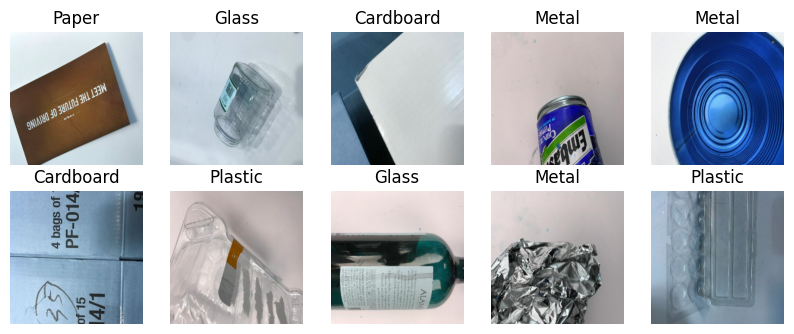

In [11]:
visualize_img(x, labels, waste_labels)

### 3) Veriyi Hazırlamak (Data Preparation)

Burda klasik makine öğrenmesi ve veri bilimine benzer işler yapacağız ancak ek olarak klasik ön işlemlerden farklı olarak görüntülere gerçek dünya özelliği ekleme işlemi gerçekleştiricez. Görüntülere gerçek dünya özellikleri ekleme ifadesi DATA AUGMENTATION olarakta karşımıza çıkabilir. 

In [12]:
# Veri artırma (data augmentation) ve veri ölçekleme (data scaling) işlemleri, genellikle eğitim ve test
# veri kümelerini hazırlarken kullanılır. İşte bu işlemlerin düzgün bir şekilde yazılmış hali:

# Eğitim/train veri seti için bir veri artırma generator tanımlanır.
train = ImageDataGenerator(
    horizontal_flip=True,          # Görüntüleri yatay olarak çevir (ağın çeşitli görünümleri öğrenmesine yardımcı olur).
    vertical_flip=True,            # Görüntüleri dikey olarak çevir (ağın çeşitli görünümleri öğrenmesine yardımcı olur).
    validation_split=0.2,          # Verinin yüzde 10'unu doğrulama veri kümesi olarak ayır (eğitim sırasında kullanılmaz).
    rescale=1./255,                # Görüntü piksel değerlerini 0 ile 1 arasında ölçekle (modelin daha iyi eğitilmesine yardımcı olur).
    shear_range=0.1,               # Görüntüleri eğme işlemi (shearing) uygular (çeşitli görünümleri öğrenmesine yardımcı olur).
    zoom_range=0.1,                # Görüntüleri rastgele yakınlaştırır (çeşitli görünümleri öğrenmesine yardımcı olur).
    width_shift_range=0.1,         # Görüntüleri yatayda kaydırır (çeşitli görünümleri öğrenmesine yardımcı olur).
    height_shift_range=0.1         # Görüntüleri dikeyde kaydırır (çeşitli görünümleri öğrenmesine yardımcı olur).
)

# Test veri seti için bir veri ölçekleme generator tanımlanır.
test = ImageDataGenerator(
    rescale=1.0 / 255,            # Görüntü piksel değerlerini 0 ile 1 arasında ölçekler (modelin daha iyi test edilmesine yardımcı olur).
    validation_split=0.2          # Verinin yüzde 10'unu doğrulama veri kümesi olarak ayır (test sırasında kullanılmaz).
)


ImageDataGenerator fonkunun görevi veri üretmektir. Gerçek zamanlı veri çeşitlendirme yapabilmektedir. Görüntü sınıflandırma, nesne algılama veya görüntü segmentasyonu gibi birçok yöntem için küçük bir görüntü kümesinden zengin, çeşitli bir görüntü kümesi oluşturma imkanı sağlar. Bunu da kırma, doldurma, çevirme, gürültü ekleme gibi teknikleri kullanarak gerçekleştirir ve böylece veri miktarı arttırılır.

Data augmentation yöntemi bir veri arttırma yöntemidir. Bizim burda özellikle gerçek dünya özelliği(gürültü) ekleme ihtiyacımızı gerçekleştirecek fonktur. 

Veri çeşitlendirme modeli küçük varyasyonlara kadar daha sağlam/ robust hale getirir. Dolayısıyla modelin aşırı uyum sağlamasını önler. 

Henüz bir test ve train seti oluşturmadık. Oluşturacak olduğumuzda hangi işlemleri yapacak olacağımızı tanımlamış olduk. Şimdi flow_from_directory fonkunu kullanarak kendi veri setimiz üzerinde ImageDataGenerator nesnesini kullanıyor olucaz. flow_from_directory fonku tensorflow ortamına görüntüleri getirmek için kullanılan bir yöntemdir. 

In [13]:
train_generator = train.flow_from_directory(
    directory=dir_path,         #veri setimizin bulunduğu dizin bilgisi
    target_size=target_size,  # Hedef boyut
    class_mode='categorical',  # Sınıf modu: çoklu sınıf sınıflandırma
    subset='training'           # Eğitim alt kümesi
)

test_generator = test.flow_from_directory(
    directory=dir_path,
    target_size=target_size,  # Hedef boyut
    batch_size=251,            # Mini toplu boyutu 
    class_mode='categorical',  # Sınıf modu: çoklu sınıf sınıflandırma  eğer ikili bir sınıflandırma yapıyor olsaydık binary yazacaktık.
    subset='validation'        # Doğrulama alt kümesi
)

Found 2024 images belonging to 6 classes.
Found 503 images belonging to 6 classes.


### 4) Modelleme (Modeling)

### 4.1) Sıfırdan CNN Modeli Kurma
* Sequential
* Evrişim Katmanı (Convolution Layer, Conv2D) 
* Havuzlama Katmanı (Pooling Layer)
* Aktivasyon Fonksiyonu Katmanı (Activation Layer) 
* Flattening Katmanı
* Dense Katmanı
* Dropout Katmanı

In [14]:
model = Sequential()    # Sinir ağı kurma yöntemi. İsminden de gördüğümüz gibi sıralı katmanlardan
                        # oluşan sinir ağlarını kurar.

#### Evrişim ve havuzlama katmanları
model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", input_shape=input_shape, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

#Buraya kadar CNN ile ilgili aslında sonrası ise klasik sinir ağı.

# Düzleştirme katmanı
model.add(Flatten())      #Veriyi sinir ağlarının anlayabileceği bir formata çeviriyoruz.

#### Dense Nöron Katmanı 
# İlk tam bağlantılı katman
model.add(Dense(units=64, activation="relu"))
model.add(Dropout(rate=0.2))

# İkinci tam bağlantılı katman      (64'lük nörondan geçtikten sonra 32'lik bir nöron setinden daha geçsin.)
model.add(Dense(units=32, activation="relu"))
model.add(Dropout(rate=0.2))

# Çıkış katmanı
model.add(Dense(units=6, activation="softmax"))# units 6 oldu çünkü 6 sınıflı bir sınıflandırma işlemi yapıyoruz.


* filters = 32 -->bir görüntü üzerinde 32 filtre gezdirilecek.
* kernel_size = (3, 3) --> gezdirilecek filtrenin boyut bilgisi 
* padding = "same"  --> Çıkış ve giriş matrisinin aynı yükseklik/ genişlik boyutuna sahip olacağı şekilde girdinin soluna- sağına veya yukarı- aşağı eşit olarak 0 piksel değerleri yerleştirilecektir bu ifadeyle.
* input_shape = (input_shape)  --> giriş görüntülerinin boyut bilgisi

* pooling = Görüntünün özelliklerini kaybetmeden  boyutunun azaltılması.(down sampling)
* pool_size = 2  --> Pooling işleminde görüntü üzerinde gezdirilecek filtrenin boyutu 2. 
* pooling işlemi convdaki performans kaybının önüne geçmek için kullanılıyor. Yani boyut azltmak için.

2'den fazla katman olunca derin sinir ağı diyebilirsin. Peki kaç katman ekleyeceğimizi, kaç filtre koyacağımızı nerrden bilicez? Hiperparametre optimizasyonu altında belirlememiz gereken değerlerdir.

Flatten Katmanı --> yz giriş verilerini tek boyutlu bir diziden alır. Flatten katmanı conv ve poolingten gelen matrisleri tek boyutlu diziye çevirir.

Dense Katmanı --> Katmanlar arasında nöron ya da düğümlerin geçişlerini sağlar. Bir katmandan aldığı nöronların diğer katmana girdi olarak bağlanmasını sağlar. Units nöron sayısını ifade eder.

Dropout Katmanı --> Aşırı öğrenmenin önüne geçmek için yani overfiti engellemek için kullanılan argüman. Sinir ağı içindeki nöronların kullanıcı tarafından belirlenen bir oranla rastgele söndürülmesi ile aşırı öğrenmeyi önler.

### 4.2) Model Özeti

In [15]:
model.summary()      # bu kod ile kurduğumuz modelin mimari yapısını gözlemlemiş oluyoruz.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0

garbage-classification	rakam-projesi-2-foto


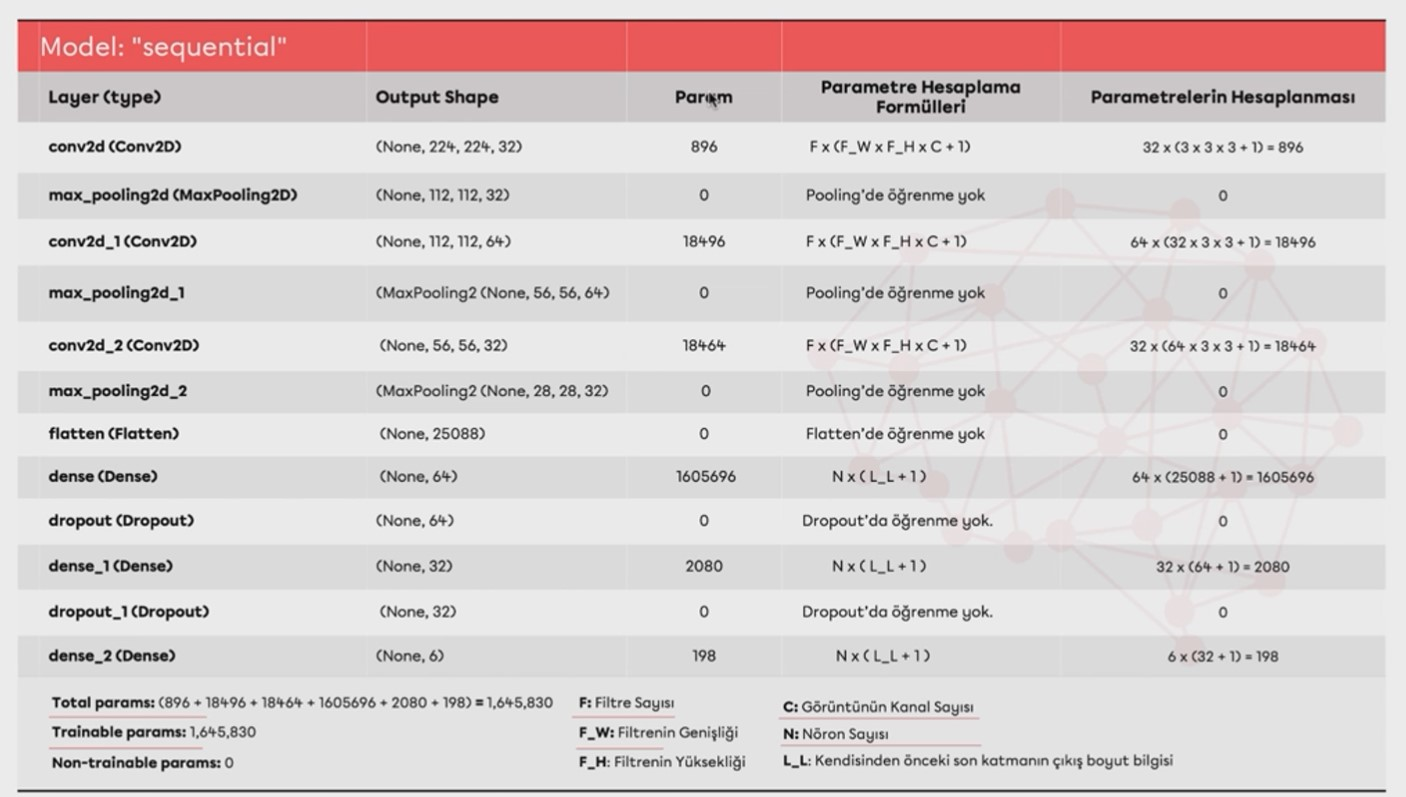

In [16]:
from IPython.display import Image
import os
!ls ../input/
Image("/kaggle/input/rakam-projesi-2-foto/2.jpg")

* Layer Type : Katmanlarımızın isimleri
* Output Spahe : Çıktıların boyut bilgisi
* Param : Bu parametreler derin sinir ağını çalıştırırken bizim model aracılığıyla bulmamız gereken parametrelerdir. Bunlar dışsal değil içsel parametrelerdir. Yani veriden model aracılığıyla bulacak olduğumuz parametrelr. Dışsal parametreler bunun kaç katmandan olacağı kaç nöron olacağı dışsal parametrelerdir. Bunlara hiper parametre denir.


Bu tablodaki ilk katmanı değerlendirelim: Output Shapede None ifadesi var bu batch size parametresi. Bununla ilgili bir bilgi vermedik. Çıkış matrisinin boyut bilgisi 224 x224. Biz girdiyi bu boyutta getirmiştik zaten. 32 ise 1. katmandaki özellik çıkarmak adına kullandığımız filtre sayısı. Bulunması gerekn parmetre sayısı 896 adet. Yani conlolution katmanında öğrenilecek olan parametre sayısı 896 tane. Burdaki parametre nasıl hesaplanıyor.
F= Filtre sayısı, 32 tane filtremiz vardı. F_W = Filtrenin genişliği, F_H = Filtrenin yüksekliği, C= Görüntü kanalının sayısı 3 kanallı bir görüntüydü. +1 ifadesi ise 32 filtre için bias değerini ifade ediyor. Filtrelere göre şekillenmiş bir parametre sayısı var burda.

MAxPooling katmanında ise output shapesi 112x112, 32 olmuş. MAx poolingi boyut azaltmak için kullanıyorduk. Poolsize2 argumanı filtrenin boyut bilgisini temsil ediyordu. Dolayısıyla burda bir indirgeme işlemi yapılıyor. Burda bir öğrenim işlemi yok. Boyut azaltarak bir indirgeme işlemi var. Dolayısıyla bir parametremizde yok. Önceki katmanı şekillendiren bir katman olarak bunu kullandık.

Bu şekillendirmeden sonra 112x112 den 64 filtreden oluşacak yeni bir katman ekliyoruz. Bu katmandaki parametre sayısı yukarıda yaptığımız gibi hesaplanıyor.

Sonrasında tekrar bir evrişim katmanı eklediğimizden dolayı tekrar bir boyut azaltma işlemi yapıyoruz. Ve 112'den 56'ya indirgenecek şekilde bir pooling işlemi gerçekleşmiş oldu.

Ve dikkat ettiğimiDe poolingten gelen boyutla yeni eklenen evrişim katmanının boyutu birbiriyle uyumlu.

Son poolingeten sonra da artık verimiz modelleme işlemine hazır hale geldi.

Flatten katmanı ile veriyi sinir ağlarının anlayacağı formata getirmiş oluyoruz.



ARtık yapay sinir ağlarının öğrenme işlemini gerçekleştirecek olan katmanlarını ekliyoruz.

Dense: 64 tane nörondan oluşan katmanı ekledik. Bu 64 nöronun ortaya çıkaracağı hesaplanacak parametre sayısı nın formülünde :
N= Nöron sayısı, +1 bias değerleri için ifade edilmiş.

Dropouta bir katman olarak bakmak yerine mevcut katmanda çalışacak bir özellik olarak bakılabilir. Burada öğrenme işlemi yok. Aşırı öğrenmenin önüne geçmek için kullanıyoruz bunu.


Flatten katmanından önceki kısım görüntülerden özellik çıkarmak. Yani evrişim katmanları görüntüden özellik çıkarmak için kullanılan katmanlar. Bu CNN özelinde olan katmanlardan sonra artık  flatten katmanı ile klasik sinir ağı yapısına geçmiş oluyoruz.

Peki Flatten katmanındaki 25088 ifadesi ne anlama geliyor. Bir önceki katmanda poolingte 28x28 ,32 ifadeleri var. Yani bu 28x28'lik 32 filtreyi ifade ediyor. Bu 3 sayının çarpımından oluşmuştur 25088. Bu yapay sinir ağına girecek olan boyut bilgisidir. 

garbage-classification	rakam-projesi-2-foto


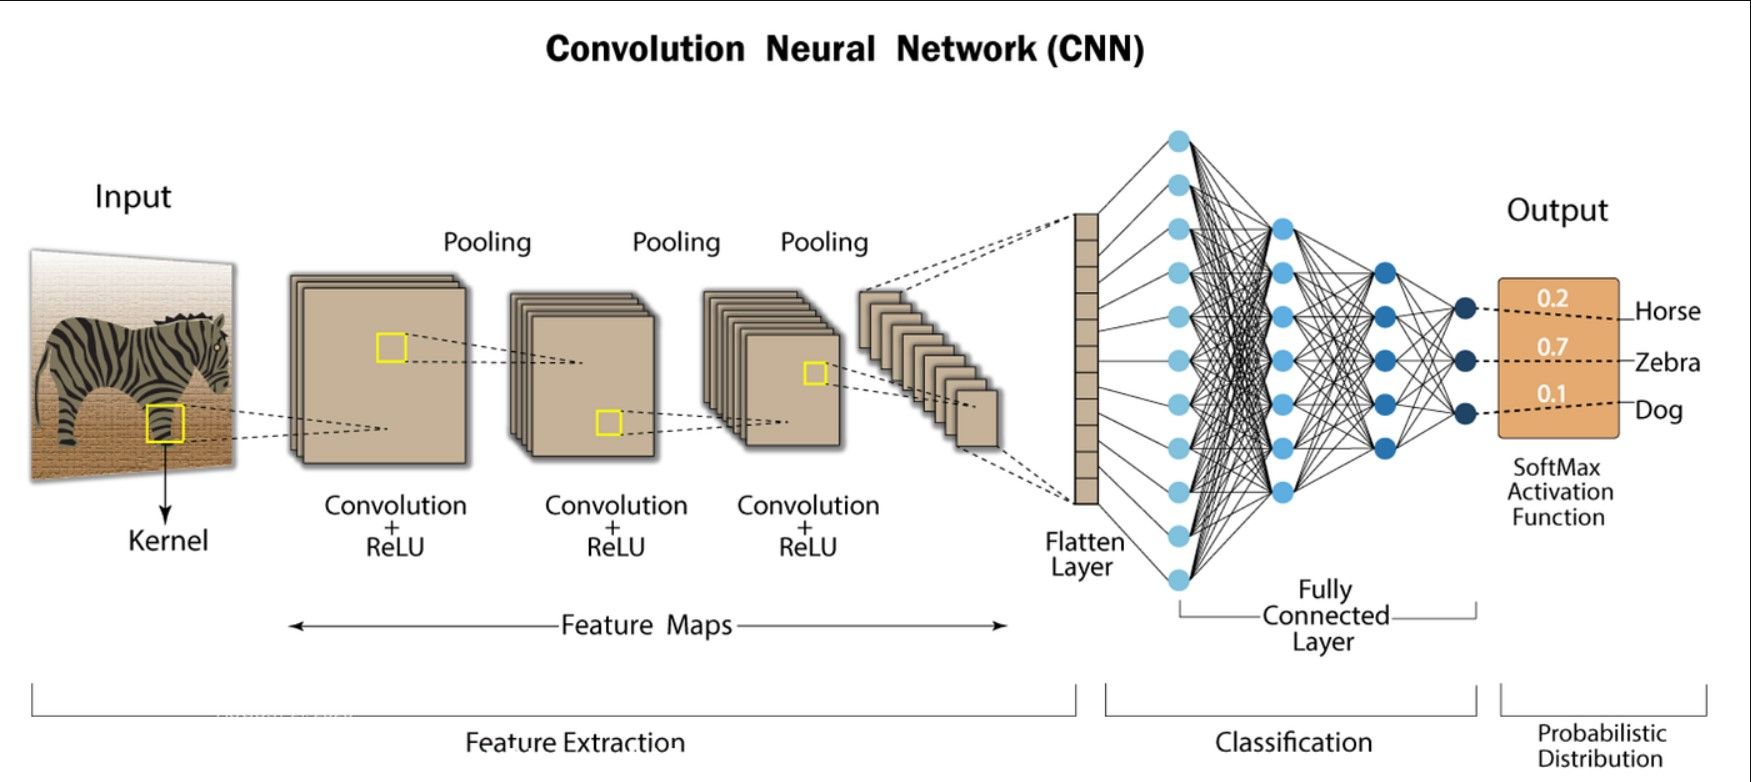

In [17]:
from IPython.display import Image
import os
!ls ../input/
Image("/kaggle/input/rakam-projesi-2-foto/3.jpg")

### 4.3) Optimizasyon ve Değerlendirme Metriklerinin Ayarlanması

Buraya kadar modelin mimari yapısını oluşturduk, katmanları gözlemledik. Şimdi optimizasyon metriklerinin yani hangi fonksiyonlara göre optimize edeceğimiz bilgisini ve değerlendirme metriklerini belirliycez.

In [18]:
# Modeli şunlara göre compile et/ derle 
model.compile(loss= "categorical_crossentropy",  # 6 sınıf olduğu için bunu kullandık. 2 sınıf olsaydı binary_crossentropy kullanacaktık.
              optimizer = "adam",  #yukarıdaki loss fonkunu minimize edicek optimizasyon yöntemi. SDC vs gibi yöntemlerde kullanılabilir. Deneyerek en iyisi bulunur.Bu problemde adam daha iyi çalıştığı için tercih ettik.
              metrics = [tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])  #eğitim ev test sırasında modelin başarısının nasıl değerlendirileceğinin ifade edileceği bölümdür.
              # Burda başarı değerlendirme metriklerini tanımlıyoruz. Bir sınıflandırma problemi olduğu için accuracy kesin gelsin dedik.
              # Dengesizlik durumlarını da yansıtsın diye recall ve precision u da gözlemlemek istedik.

Şu anda fit etme işlemi hala başlamadı, hala özellik tanımlıyoruz. Daha önce tanımladıklarımız sinir ağının dışsal özellikleriydi, mimari yapısıydı. Yani dış kısmı tamamladık artık iç ve hassas bölgelere giriyoruz.

Sinir ağlarının öğrenmekle ilgili bir sıkıntısı yok hatta aşırı öğrenme gibi bir sıkıntıları var. Bunun önüne geçmek için birtakım işlemler yapcaağız.

In [19]:
# 1) Early Stopping: Model öğrenimini sürdürürken bir noktadan sonra aşırı öğrenmeye yönelmeye başlarsa 
# yani train setinin hatası düşüp test setininki yükselmeye başlarsa dur diyoruz. Bunu early stopping 
# ile gerçekleştiriyoruz. 

callbacks = [
    EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'),
    ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
]

Callbck ne demek? Sinir ağını eğitirken iterasyonları, gerekli early stopping kontrolünü yapmak, iterasyonları kaydetmek, model bilgilerini kaydetmek adına böyle bir liste oluşturduk.

İçindeki EarlyStopping model ezberlemey başlaığında durmayı ifade edr.
Monitor = Modelin gelişimini aşırı öğrenmeyi engellemek adına hangi metrik açısından tkip edicez sorusunun yanıtıdır. Validasyon lossundaki ilerleme ya da ilerlememe durumuna göre dur diyoruz. Peki nerde durack? Patience :50 yani 50 adımda ilerleme olmazsa dur artık dedik. 50 epoch/ iterasyonda artık ilerleme olmadığını gözlemlersem dur artık. Çünkü öğrenme değil ezberlemey başlamıştır artık. Bu esnada trainin başarısı artmaya devam edeceğinden dolayı gözlemlemş olacağız. Veya loss küçülmeye devam edecek ama validasyonda bir ilerleme yoksa bu ezberlenmeye başladığını ifade edeceğinden dolayı adım sayısını /epochu ifade ediyoruz.
verbose ise 0,1 ya da 2 değerlerini alabilir. 0 yazarsak ekranda hiçbir sonuç yazmadan işlem ilerler. 2 yazarsak her epochta bilgilendirme yapar. 1 ise progress bar (ilerleme süreç çubuğu) gibi anlık güncellenen sonuçları gösterir.
mode ise model gelişiminin takip edileceği parametre değerleri vardır min, max, otomatik gibi. Min modunda izlenen miktarın azalması durduğnda eğitim durur. MAx modunda izlenen miktarın artması durduğunda eğitim durur. Otomatikte ise izlenen miktarın ardından otomotik oalrak çıkarılır.


ModelCheckPoint bölümü, model iterasyonları devam ederken yakalanacak olan en iyi modelin kaydedilmesi işlemini bu fonku kullanarak gerçekleştiririz. Modeli izleme gibi bir özellik.
filepath= ilgili modeli ne şekilde kaydedeceğimiz bilgisini veriyoruz.
monitor= Gözlemlemek adına val loss'a odaklanmıştık.





Callback'ler, eğitim sürecini izlemek ve kontrol etmek için kullanılır.

callbacks = [ ... ]: Callback'leri içeren bir liste oluşturuyoruz. Bu listede, eğitim süreci sırasında kullanmak istediğiniz callback'leri saklayacaksınız.

EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min'): İlk callback olan EarlyStopping'i tanımlar. Bu, eğitim sürecini belirli bir koşula göre durduran bir callback'tir. Ayrıntıları şu şekildedir:

monitor='val_loss': Eğitim süreci sırasında takip edilecek metrik, burada doğrulama kaybı (val_loss) olarak ayarlanmıştır.
patience=50: Eğer doğrulama kaybı 50 epok boyunca iyileşmezse, eğitimi durdurur.
verbose=1: Callback'in çıktı vermesini sağlar, böylece süreci takip edebilirsiniz.
mode='min': İzlenen metriğin nasıl optimize edileceğini belirler. Burada, kaybın minimize edilmesi isteniyor.
ModelCheckpoint(filepath='mymodel.h5', monitor='val_loss', save_best_only=True, save_weights_only=False, mode='min'): İkinci callback olan ModelCheckpoint'i tanımlar. Bu, her belirli sayıda epok sonra modelin ağırlıklarını kaydeden bir callback'tir. Ayrıntıları şu şekildedir:

filepath='mymodel.h5': Modelin ağırlıklarının kaydedileceği dosyanın adını belirtir.
monitor='val_loss': Takip edilecek metrik, yine doğrulama kaybı (val_loss) olarak ayarlanmıştır.
save_best_only=True: Yalnızca en iyi model ağırlıklarının kaydedilmesini sağlar. Yani doğrulama kaybı azaldığında kaydedilir.
save_weights_only=False: Modelin sadece ağırlıklarının değil, tüm modelin kaydedilmesini sağlar.
mode='min': İzlenen metriğin minimize edilmesini isteniyor.

save_best_only=True  sadece en iyi modeli kaydet dedik.
save_weights_only=False  bunu True yaparsak sadece modelin ağırlıklarını kaydeder. False yaparsak bütün modeli kaydeder.

### 4.4) Modelin Eğitilmesi

In [20]:
history = model.fit_generator(
    generator=train_generator,      # Eğitim veri üreteci (veri girişi)
    epochs=50,                     # Epok sayısı (ne kadar süre boyunca eğitim yapılacağı)
    validation_data=test_generator,  # Doğrulama veri üreteci (eğitim sonuçlarının değerlendirileceği veri)
    callbacks=callbacks,            # Model eğitme sürecinde çeşitli aşamalardaki modelin aşırı öğrenmesinin önüne geçek adına nerde durabileceğini ifade edecek early stoppingti ve modelin kaydedilmesiyle ilgili bilgileri barındırıyor.
    workers=4,                      # Eğitim işlemi sırasında kullanılacak işçi (worker) sayısı (Donanımsal)
    steps_per_epoch=2024 // 32,     # Her epokta tamamlanacak adım (batch) sayısı  # 2024adet verimiz var. 2024/32=71 yani her epochta 71 sample ile model eğitimi gerçekleşecek.
    validation_steps=503 // 32      # Doğrulama sırasında kullanılacak adım (batch) sayısı (test setinde 503 gözlem vardı)
)


Epoch 1/50
63/63 [==============================] - ETA: 0s - loss: 1.9052 - precision: 0.0857 - recall: 0.0030 - acc: 0.1923
Epoch 1: val_loss improved from inf to 1.77788, saving model to mymodel.h5
63/63 [==============================] - 33s 366ms/step - loss: 1.9052 - precision: 0.0857 - recall: 0.0030 - acc: 0.1923 - val_loss: 1.7779 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.2107
Epoch 2/50
62/63 [============================>.] - ETA: 0s - loss: 1.7671 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.2367
Epoch 2: val_loss improved from 1.77788 to 1.75562, saving model to mymodel.h5
63/63 [==============================] - 19s 296ms/step - loss: 1.7673 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.2334 - val_loss: 1.7556 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_acc: 0.2346
Epoch 3/50
62/63 [============================>.] - ETA: 0s - loss: 1.7495 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.2332
Epoch 3: val_loss im

Burdaki loss gerçek değerler ile tahmin ettiğimiz değerlerin aslında birbirlerine ne kadar yakın veya uzak oldupunu ifade ediyor. Dolayısıyla loss ne kadar düşükse tahminlerimiz o kadar başarılıdır anlamına geliyor. 

Early Stopping eğer validasyon accuracysinde ilerleme sağlanamıyorsa duruyor olacak.

Buraya kadar ne yapmış olduk? Hem iç hem dış özelliklerle ilgilendik. İç kısım diyebileceğimiz optimizasyon yöntemini, optimize edilecek fonku, başarı metriklerini tanımladık ve eğitim süresi devam edrken nerede durmamız gerektiğini ifade edecek olan early stoppingi ve model takibini sağlamak için model check pointi kullanarak artık tamamen modeli fit etme sürecei başlatma adımına geldik.

### 4.5) Accuracy ve Loss Grafikleri


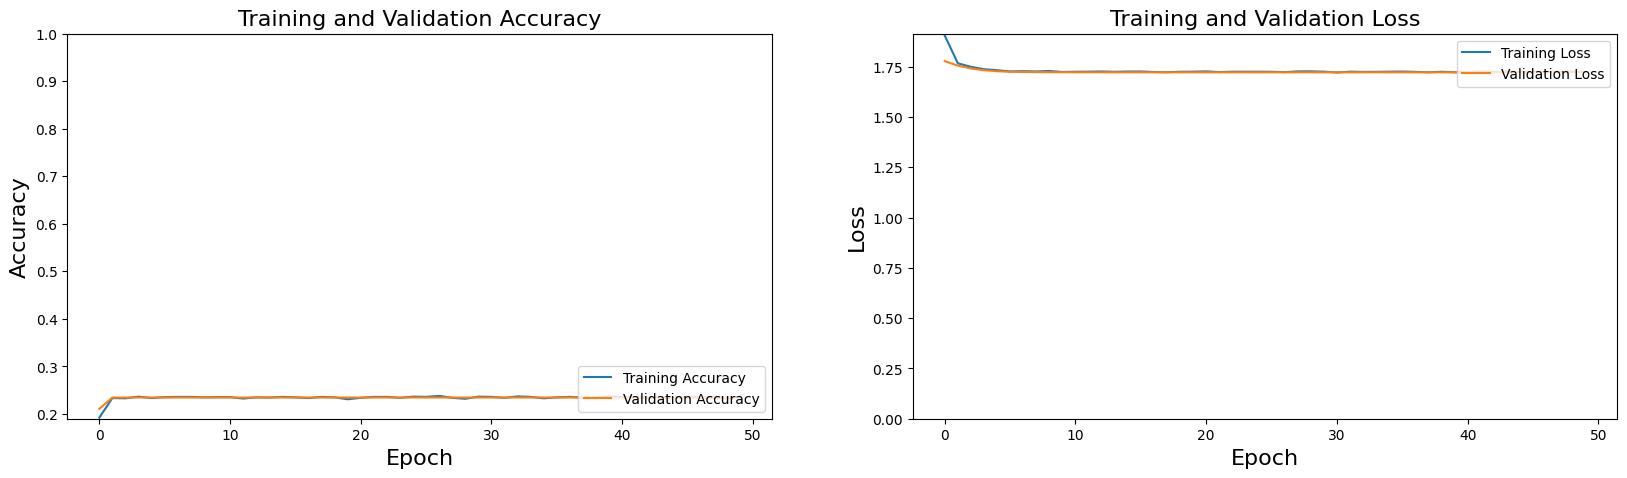

In [21]:
# Accuracy Grafiği
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy', fontsize=16)

# Loss Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0, max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)

plt.show()


### 5) Değerlendirme (Evaulation)

In [22]:
loss, precision, recall, acc= model.evaluate(test_generator, batch_size=32)

3/3 [==============================] - 2s 374ms/step - loss: 1.7226 - precision: 0.0000e+00 - recall: 0.0000e+00 - acc: 0.2346


Normalde bunların en iyi modelin sonuçları olması gerekirdi.

In [23]:
print("\nTest accuracy: %.1f%%" % (100.0 * acc))
print("\nTest loss: %.1f%%" % (100.0 * loss))
print("\nTest precision: %.1f%%" % (100.0 * precision))
print("\nTest recall: %.1f%%" % (100.0 * recall))



Test accuracy: 23.5%

Test loss: 172.3%

Test precision: 0.0%

Test recall: 0.0%


Test veri setinin modele sorulabilmesi için pixel ve gerçek değerlere ihtiyacımız var. Next fonkunu kullanarak x_Test ve y_testi bulucaz. 

In [24]:
#Test setindeki görüntüleri modele soruyoruz. 
# Classification Report
x_test, y_test = test_generator.next()
y_pred = model.predict(x_test)

8/8 [==============================] - 0s 30ms/step


In [25]:
#y_pred       # Tahmin olasılıkları değerleri:

Ama biz tahmin olasılıkları değeri yerine hangi sınıfın tahmin edildiği bilgisi gerekiyor. 

In [26]:
y_pred = np.argmax(y_pred)     # y_predeler içinden maxı alma 
y_test = np.argmax(y_test)     # y_testin sınıf cinsinden değerleri

In [27]:
print(y_test.shape, y_pred.shape)


() ()


In [28]:
target_names = list(waste_labels.keys())
print(classification_report(y_test, y_pred, target_names=target_names))

TypeError: Singleton array 2 cannot be considered a valid collection.

2 sınıflı bir sınıflandırma probleminde precision değeri 1 olarak tahmin ettiğimiz tahmin değerlerinin ne kadar isabetli olduğunu ifade ediyor. REcall ise gerçekte 1 olan sınıfları ne kadar doğru yakalayabildiğimizi ifade ediyor. F1 skoru bu iki değerin harmonik ortalamasıdır. Accuracy ise doğru sınıflandırma oranı yani acc 73 ise 100 gözlemden 73 tanesini doğru sınıflandırmışsın dmeke.

Bu fonk bize görsel bir şekilde modelimizin tahmin başarısına yönelik olarak bir çıktı sağlıyor olacak. 

In [ ]:
# Confusion matrix

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.0

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontweight="bold")
    plt.xlabel('Predicted label', fontweight="bold")

# Example usage:
# Assuming cm is your confusion matrix and classes is a list of class names
# plot_confusion_matrix(cm, classes)


In [ ]:
plot_confusion_matrix(cm, waste_labels.keys(), title='Confusion matrix', cmap=plt.cm.OrRd)

In [ ]:
import numpy as np
from keras.preprocessing import image

waste_labels = {0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

def model_testing(path, target_size=(224, 224)):
    """
    Perform prediction on an image using the model.

    Parameters:
    path: Directory where the images are located.
    target_size: Target size for resizing the input image.

    Returns:
    img: The image.
    p: Prediction probabilities.
    predicted_class: Predicted class.
    """
    img = image.load_img(path, target_size=target_size)
    img = image.img_to_array(img, dtype=np.uint8)
    img = img / 255.0
    p = model.predict(img.reshape(1, 224, 224, 3))
    predicted_class = np.argmax(p[0])
    return img, p, predicted_class

# Example usage:
#img1, p1, predicted_class1 = model_testing('xxmetal100.jpg')
#img2, p2, predicted_class2 = model_testing('yyglass105.jpg')
#img3, p3, predicted_class3 = model_testing('zz/cardboard103.jpg')
#img4, p4, predicted_class4 = model_testing('kkpaper106.jpg')


In [ ]:
plt.figure(figsize=(20, 60))

# Subplot 1
plt.subplot(141)
plt.axis('off')
plt.imshow(img1.squeeze())
plt.title("Maximum Probability: " + str(np.max(p1[0], axis=-1)) + "\nPredicted class: " + str(waste_labels[predicted_class1]))

# Subplot 2
plt.subplot(142)
plt.axis('off')
plt.imshow(img2.squeeze())
plt.title("Maximum Probability: " + str(np.max(p2[0], axis=-1)) + "\nPredicted class: " + str(waste_labels[predicted_class2]))

# Subplot 3
# Add more subplots as needed

plt.show()


plt.subplot(143)
plt.axis('off')
plt.imshow(img3.squeeze())
plt.title("Maximum Probability: " + str(np.max(p3[0], axis=-1)) + "\nPredicted class: " + str(waste_labels[predicted_class3]))

plt.subplot(144)
plt.axis('off')
plt.imshow(img4.squeeze())
plt.title("Maximum Probability: " + str(np.max(p4[0], axis=-1)) + "\nPredicted class: " + str(waste_labels[predicted_class4]))

plt.show()


ModelCheckpoint, en iyi durumu kaydeder, EarlyStopping ise belirli bir kriter karşılandığında eğitimi durdurur. Birlikte kullanıldıklarında, model eğitimini daha verimli ve kontrol altında tutmaya yardımcı olabilirler.
